[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/swsuh28/paper_tvd_nn/blob/main/2_first_revision_JCP/code/demo-mod.ipynb)

## Overview

This notebook demonstrates numerical experiments from *A TVD neural network closure and application to turbulent combustion* by S. W. Suh, J. F. MacArt, L. N. Olson, and J. B. Freund.

## Requirements

- torch
- numpy
- matplotlib
- scipy
- tqdm

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.optimize import fsolve

from tqdm import tqdm
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64) # use double precision

## Baseline NN architecture

Defines a baseline NN model $f_{\mathcal N} \in \mathcal{N}$ described in (2.5).

In [17]:
class baseNN(nn.Module):
    def __init__(self, Ni, Nh, No):
        """Baseline NN architecture.
        
        Parameters
        ----------
        Ni : int
            Number of units in input layer.
        Nh : int
            Number of units per hidden layer.
        No : int
            Number of units in output layer.
        """
        super(baseNN, self).__init__()
        
        self.fc0 = nn.Linear(Ni, Nh)
        self.fc1 = nn.Linear(Nh, Nh)
        self.fc2 = nn.Linear(Ni, Nh)
        self.fc3 = nn.Linear(Nh, Nh)
        self.fc4 = nn.Linear(Ni, Nh)
        self.fc5 = nn.Linear(Nh, No)
        
        self.layers = [
            self.fc0,
            self.fc1,
            self.fc2,
            self.fc3,
            self.fc4,
            self.fc5
        ]
        
        # Initialize weights and biases
        for l in self.layers:
            nn.init.xavier_uniform_(l.weight.data)
            nn.init.zeros_(l.bias.data)
        nn.init.zeros_(self.layers[-1].weight.data)
        
        # Activation function
        self.act = lambda x: torch.tanh(x)
        
    def forward(self, x):
        """Forward propagation.

        Parameters
        ----------
        x : Tensor
            Model input.
            
        Returns
        -------
        y : Tensor
            Model output.
        """
        H1 = self.act(self.fc0(x))
        H2 = self.act(self.fc1(H1))
        G1 = self.act(self.fc2(x))
        H3 = G1*H2
        H4 = self.act(self.fc3(H3))
        G2 = self.act(self.fc4(x))
        H5 = G2*H4
        y = self.fc5(H5) # output
        return y

## Unconstrained NN closure model

Define an unconstrained model described in (2.4).

In [40]:
class nnSolverUnconstrained:
    def __init__(self, dim, dt, dx, bc, q0, q_tru, Nt):
        """1D PDE solver with unconstrained NN closure.
        
        Parameters
        ----------
        dim : tuple
            Dimension of a baseNN model.
        dt : float
            Time step size.
        dx : float
            Grid spacing.
        bc : bool
            Switch for boundary conditions.
            True if using 1st-order accurate Neumann bc.
            False if using periodic bc.
        q0 : Tensor
            Initial condition.
        q_tru : Tensor
            True solution.
        Nt : int
            Number of time steps.
        """
        Ni, Nh, No = dim # unzip NN dimension
        self.dt = dt
        self.dx = dx
        self.bc = bc
        self.q0 = q0
        self.q_tru = q_tru
        self.Nt = Nt
        
        self.f = baseNN(Ni, Nh, No) # NN flux
        self.models = nn.ModuleList([self.f])
        self.optimizer = optim.RMSprop(
            self.models.parameters(),
            lr=1e-3
        ) # NN optimizer
    
    def prolongate(self, q):
        """Prolongate solution for Neumann bc.
        
        Parameters
        ----------
        q : Tensor
            State to prolongate.
        
        Returns
        -------
        qb : Tensor
            Prolongated state.
        """
        if self.bc:
            # Prolongate solution to ghost cells
            qb = torch.zeros(q.shape[0]+4, q.shape[1])
            qb[:2,:] = q[0,:].clone()
            qb[-2:,:] = q[-1,:].clone()
            qb[2:-2,:] = q.clone()
        else:
            qb = q
        return qb
    
    def restrict(self, rhs):
        """Restrict RHS for Neumann bc.
        
        Parameters
        ----------
        rhs : Tensor
            Possibly prolongated RHS values.
        
        Returns
        -------
        rhs_i : Tensor
            RHS values restricted to internal points.
        """
        if self.bc:
            # Restrict solution to interior points
            rhs_i = rhs[2:-2,:]
        else:
            rhs_i = rhs
        return rhs_i
    
    def rhs(self, q):
        """Return divergence of unconstrained NN flux.
        
        Parameters
        ----------
        q : Tensor
            State at internal points.
        
        Returns
        -------
        rhs_i : Tensor
            RHS values at internal points.
        """
        qb = self.prolongate(q) # prolongated q_i
        qp = torch.roll(qb, -1, 0) # q_{i+1}
        q_in = torch.cat((qp, qb), dim=1) # input stencil
        f = self.f(q_in) # flux at x_{i+1/2}
        rhs = -(f-torch.roll(f,1,0))/self.dx # take a finite differnce
        rhs_i = self.restrict(rhs) # restricted RHS at x_i
        return rhs_i
    
    def solve(self):
        """Integrate a NN-embedded PDE (2.3) for Nt steps.
        
        Returns
        -------
        q : Tensor
            Solution.
        """
        q = self.q0.clone()
        q.requires_grad = True
        for i in range(self.Nt):
            # Time-integration with explicit Euler
            q = q + self.dt*self.rhs(q)
        return q
    
    def rescale(self):
        """Placeholder for rescaling: to be used in constrained NN."""
        pass
    
    def step(self):
        """Take a gradient descent (GD) step.
        
        Returns
        -------
        loss : Tensor
            Loss after the GD step (detached).
        """
        q_ml = self.solve() # model-predicted solution
        loss = torch.sum((q_ml-self.q_tru)**2)*self.dx # pointwise mismatch (2.8)
        loss.backward() # backpropagate
        self.optimizer.step() # take a GD step
        self.rescale() # rescale (nothing happens in unconstrained NN)
        return loss.detach()

## Constrained NN closure model

Next, define a TVD NN closure (2.11) and (2.19).

In [41]:
class nnSolverConstrained(nnSolverUnconstrained):
    def __init__(self, *args):
        """1D PDE solver with constrained NN closure."""
        super(nnSolverConstrained, self).__init__(*args)
        self.amax = 0 # maximum wave speed
        
    def get_f_a(self, q):
        """Evaluate the NN flux f and an approximate wave speed a (2.22).
        
        Parameters
        ----------
        q : Tensor
            State.
        
        Returns
        -------
        f, a : (Tensor, Tensor)
            NN flux and wave speed at grid points coinciding with q.
        """
        f = self.f(q) # forward propagate
        fsum = torch.sum(torch.abs(f))
        fsum.backward(retain_graph=True, inputs=q)
        a = torch.abs(q.grad.data)
        a, _ = torch.max(a, dim=1, keepdim=True) # 1-norm of flux Jacobian
        return f, a
    
    def minmod(self, a, b):
        """Minmod function.
        
        minmod(a, b) = a  if  ab >= 0 & |a| <= |b|
                       b  if  ab >= 0 & |a| >  |b|
                       0  if  ab < 0
        Parameters
        ----------
        a : Tensor
            First state.
        b : Tensor
            Second state.
        
        Returns
        -------
        out : Tensor
            Evaluated minmod function at grid points.
        """
        out = 0.5*(torch.sign(a)+torch.sign(b))*\
                torch.minimum(torch.abs(a),torch.abs(b))
        return out
    
    def rhs(self, q):
        """Overrides unconstrained NN RHS."""
        # Reconstruct
        qb = self.prolongate(q)
        qp = torch.roll(qb, -1, 0)
        qm = torch.roll(qb, +1, 0)
        s = self.minmod(qp-qb, qb-qm) # limited slope
        qr = qp - 0.5*torch.roll(s, -1, 0) # q_{i+1/2}^+
        ql = qb + 0.5*s # q_{i+1/2}^-
        
        # Compute flux and wave speed
        fr, ar = self.get_f_a(qr)
        fl, al = self.get_f_a(ql)
        a = torch.maximum(ar, al) # a_{i+1/2}
        self.amax = max(self.amax, torch.max(a)) # update maximum wave speed
        fph = 0.5*(fr+fl-a*(qr-ql)) # f_{i+1/2}
        fmh = torch.roll(fph, 1, 0) # f_{i-1/2}
        rhs = -(fph-fmh)/self.dx # take a finite difference
        rhs_i = self.restrict(rhs) # restrict RHS
        return rhs_i
    
    def rescale(self):
        """Rescaling based on Algorithm 1."""
        for i in range(100): # max no. of sub-iteration is 100
            cfl = self.amax*self.dt/self.dx # max CFL during prediction
            cfl_max = 0.5 # max allowable CFL number for central schemes
            if cfl > cfl_max:
                with torch.no_grad():
                    self.f.layers[-1].weight.data *= cfl_max/cfl
                self.amax = 0
                _ = self.solve() # Solve PDE again
            else:
                break

## Scenario #1: 1D advection

We first demonstrate our method for the 1D advection problem in Section 3.1.

In [20]:
class advection:
    def __init__(self):
        """Baseline config class."""
        # Spatial discretization
        self.Lx = 1 # domain length
        self.Nx = 100 # number of grid points
        self.dx = self.Lx/self.Nx # grid spacing
        self.x = torch.arange(self.Nx)*self.dx # spatial grid
        
        # Time discretization
        self.dt = 0.25*self.dx # time step size
        self.tf = 0.2 # final simulation time
        self.Nt = int(self.tf/self.dt) # number of time steps
        
        # Boundary conditions
        self.bc = False # periodic bc
        
        # Initial condition and exact solution
        self.q0, self.q_tru = self.getExactSol()
        
        self.varnames = [r'$q$'] # variable names for plots
        
        self.Ntrain = 1000 # number of training iterations
        self.Nh = 10 # number of units per hidden layer
        
        self.solver_u = nnSolverUnconstrained(
            (2, self.Nh, 1),
            self.dt,
            self.dx,
            self.bc,
            self.q0,
            self.q_tru,
            self.Nt
        )
        self.solver_c = nnSolverConstrained(
            (1, self.Nh, 1),
            self.dt,
            self.dx,
            self.bc,
            self.q0,
            self.q_tru,
            self.Nt
        )
        self.solvers = [self.solver_u, self.solver_c] # iterator for nnSolvers
    
    def getExactSol(self):
        """Get exact solution of 1D advection equation.
        
        Returns
        -------
        q0, q_tru : (Tensor, Tensor)
            Initial condition (q0) and exact solution at self.tf (q_tru).
        """
        q0 = torch.where(
            self.x>0.5,
            torch.ones_like(self.x),
            torch.zeros_like(self.x)
        )
        q0 = 0.5*(q0+torch.roll(q0,1,0))
        q_tru = torch.roll(q0, int(self.Nx*self.tf))
        return q0.view(-1,1), q_tru.view(-1,1) # reshape
        
    def train(self, solver):
        """Train a NN model.
        
        Parameters
        ----------
        solver
            Solver with a NN model to train.
        """
        for i in tqdm(range(self.Ntrain)):
            loss = solver.step()
            if i==0:
                loss_i = loss.detach().clone()
            elif i==self.Ntrain-1:
                loss_f = loss.detach().clone()
                print('Initial loss:', loss_i.item())
                print('Final loss:', loss_f.item())
    
    def solve(self, solver):
        """Solve a NN-embedded PDE.
        
        Parameters
        ----------
        solver
            Solver with a NN model to train.
                 
        Returns
        -------
        sol : Tensor
            Solution.
        """
        sol = solver.solve()
        return sol

#### Train the model

In [21]:
adv = advection()
adv.train(adv.solver_u)  # unconstrained solver
adv.train(adv.solver_c)  # constrained solver

100%|██████████| 1000/1000 [00:34<00:00, 28.97it/s]


Initial loss: 0.39
Final loss: 0.0021238261425667927


100%|██████████| 1000/1000 [02:04<00:00,  8.03it/s]

Initial loss: 0.39
Final loss: 0.002834006870312143


#### Apply the model

In [22]:
sol_u = adv.solver_u.solve().detach()  # solve with the unconstrained model
sol_c = adv.solver_c.solve().detach()  # solve with the constrained model

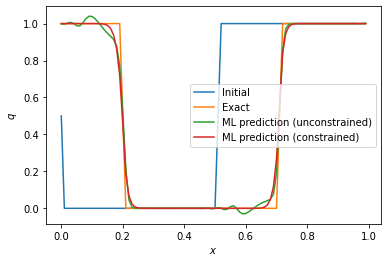

In [23]:
fig, ax = plt.subplots()
ax.plot(adv.x, adv.q0, label='Initial')
ax.plot(adv.x, adv.q_tru, label='Exact')
ax.plot(adv.x, sol_u, label='ML prediction (unconstrained)')
ax.plot(adv.x, sol_c, label='ML prediction (constrained)')
ax.set_xlabel(r'$x$')
ax.set_ylabel(adv.varnames[0])
plt.legend()

## Scenario #2: 1D Burgers

Demo for 1D Burgers equation in Section 3.2.

In [24]:
class burgers(advection):
    """Config for Burgers equation."""
    def getExactSol(self):
        """Get exact solution of 1D Burgers equation.
        
        Returns
        -------
        q0, q_tru : (Tensor, Tensor)
            Initial condition (q0) and exact solution at self.tf (q_tru).
        """
        w = 0.25
        q0 = torch.where(
            abs(self.x-0.5)<0.5*w,
            torch.ones_like(self.x),
            torch.zeros_like(self.x)
        )
        q_tru = torch.where(
            self.x<0.5*self.Lx-0.5*w,
            torch.zeros_like(self.x),
            torch.where(
                self.x<0.5*self.Lx+0.5*w,
                (self.x-0.5*self.Lx+0.5*w)/w,
                torch.where(self.x<0.5*self.Lx+w,
                    torch.ones_like(self.x),
                    torch.zeros_like(self.x)
                )
            )
        )
        return q0.view(-1,1), q_tru.view(-1,1)

#### Train the model

In [25]:
burg = burgers()
burg.train(burg.solver_u)  # unconstrained solver
burg.train(burg.solver_c)  # constrained solver

100%|██████████| 1000/1000 [00:32<00:00, 31.21it/s]


Initial loss: 0.20330000000000004
Final loss: 0.001107694302453148


100%|██████████| 1000/1000 [02:02<00:00,  8.18it/s]

Initial loss: 0.20330000000000004
Final loss: 0.0024173717126929747


#### Apply the model

In [26]:
sol_u = burg.solver_u.solve().detach()  # solve with the unconstrained model
sol_c = burg.solver_c.solve().detach()  # solve with the constrained model

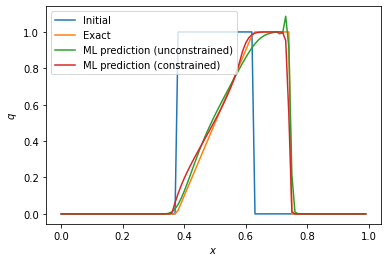

In [27]:
fig, ax = plt.subplots()
ax.plot(burg.x, burg.q0, label='Initial')
ax.plot(burg.x, burg.q_tru, label='Exact')
ax.plot(burg.x, sol_u, label='ML prediction (unconstrained)')
ax.plot(burg.x, sol_c, label='ML prediction (constrained)')
ax.set_xlabel(r'$x$')
ax.set_ylabel(burg.varnames[0])
plt.legend()

## Scenario #3: 1D Euler equations

Demo for 1D Euler equations in Section 3.3

#### Sod Problem

In [28]:
gamma = 1.4
stateL = (1.0  ,1.0,0.0)
stateR = (0.125,0.1,0.0)

def sod_init(x):
    """Initial state.

    Parameters
    ----------
    x : Tensor
        Grid points in 1D.

    Returns
    -------
    qp : Tensor
        Primitive variables (density, velocity, pressure).
    qc : Tensor
        Conserved variables (density, momentum, energy).
    """
    Nx = len(x)
    qp = torch.zeros((Nx, 3))
    qc = torch.zeros((Nx, 3))
    rhoL,pL,uL = stateL
    rhoR,pR,uR = stateR
    ones = torch.ones(Nx)
    rho = torch.where(x<0.5,ones*rhoL,ones*rhoR)
    u   = torch.where(x<0.5,ones*uL  ,ones*uR  )
    p   = torch.where(x<0.5,ones*pL  ,ones*pR  )
    qp = torch.stack((rho,u,p),axis=1)
    qc = p2c(qp)
    return qp,qc

def p2c(qp):
    """Transform primitive to conserved variables.
    
    Parameters
    ----------
    qp : Tensor
        Primitive variables.
    
    Returns
    -------
    qc : Tensor
        Conserved variables.
    """
    rho = qp[:,0]
    u   = qp[:,1]
    p   = qp[:,2]
    qc = torch.zeros_like(qp)
    qc[:,0] = rho
    qc[:,1] = rho*u
    qc[:,2] = p/(gamma-1)+0.5*rho*u**2
    return qc

def c2p(qc):
    """Transform conserved to primitive variables.
    
    Parameters
    ----------
    qc : Tensor
        Conserved variables.
    
    Returns
    -------
    qp : Tensor
        Primitive variables.
    """
    rho = qc[:,0]
    m   = qc[:,1]
    E   = qc[:,2]
    qp = torch.zeros_like(qc)
    qp[:,0] = rho
    qp[:,1] = m/rho
    qp[:,2] = (gamma-1)*(E-0.5*m**2/rho)
    return qp

def sod_solve(x,t):
    """Solve ths Sod shock tube problem at (x,t).
    
    Parameters
    ----------
    x : Tensor
        Grid points in 1D.
    t : float
        Time.
    
    Returns
    -------
    qc : Tensor
        Solution in conserved variables.
    """
    rhoL,pL,uL = stateL
    rhoR,pR,uR = stateR

    if t >= 0.5/np.sqrt(gamma*pL/rhoL):
        print('Not available after the shock reaches the boundary')
        return None
    
    cL = np.sqrt(gamma*pL/rhoL)
    cR = np.sqrt(gamma*pR/rhoR)
    
    Gamma = (gamma-1)/(gamma+1)
    beta = (gamma-1)/2/gamma
    expr = lambda p: (p-pR)*np.sqrt((1-Gamma)/rhoR/(p+Gamma*pR))-\
                     (pL**beta-p**beta)*np.sqrt((1-Gamma**2)*pL**(1/gamma)/Gamma**2/rhoL)
    
    p3 = torch.from_numpy(fsolve(expr,0.5*(pL+pR)))
    u3 = uR+(p3-pR)/torch.sqrt(rhoR/2*((gamma+1)*p3+(gamma-1)*pR))
    rho3 = rhoL*(p3/pL)**(1/gamma)
        
    p4 = p3
    rho4 = rhoR*(p4+Gamma*pR)/(pR+Gamma*p4)
    u4 = u3
        
    u2 = 2/(gamma+1)*(cL+(x-0.5)/t)
    rho2 = rhoL*(1-(gamma-1)/2*u2/cL)**(2/(gamma-1))
    p2 = pL*(1-(gamma-1)/2*u2/cL)**(2*gamma/(gamma-1))
        
    x12 = 0.5-cL*t
    c2 = cL-(gamma-1)/2*u4
    x23 = 0.5+(u3-c2)*t
    cshock = u4*(rho4/rhoR)/(rho4/rhoR-1)
    x34 = 0.5+u4*t
    x45 = 0.5+cshock*t
        
    rho = torch.where(x<x12,rhoL,\
            torch.where(x<x23,rho2,\
                torch.where(x<x34,rho3,\
                    torch.where(x<x45,rho4,rhoR))))
        
    u = torch.where(x<x12,uL,\
            torch.where(x<x23,u2,\
                torch.where(x<x34,u3,\
                    torch.where(x<x45,u4,uR))))
        
    p = torch.where(x<x12,pL,\
            torch.where(x<x23,p2,\
                torch.where(x<x34,p3,\
                    torch.where(x<x45,p4,pR))))
        
    qp = torch.stack((rho,u,p),axis=1)
    qc = p2c(qp)
    
    return qc

In [29]:
class euler(advection):
    """Config for Euler equation.
    
    Here we use coarser discretization & less complex model for faster turnaround.
    """
    def __init__(self):
        super(euler, self).__init__()
        self.Lx = 1
        self.Nx = 200
        self.dx = self.Lx/self.Nx
        self.x = torch.arange(self.Nx)*self.dx

        self.dt = 0.1*self.dx
        self.tf = 0.05
        self.Nt = int(self.tf/self.dt)
        
        self.bc = True
        
        self.q0, self.q_tru = self.getExactSol()
        
        self.varnames = [
            r'$\rho$',
            r'$\rho u$',
            r'$E$'
        ]
        
        self.Ntrain = 200
        self.Nh = 20
        self.solver_u = nnSolverUnconstrained(
            (6, self.Nh, 3),
            self.dt,
            self.dx,
            self.bc,
            self.q0,
            self.q_tru,
            self.Nt
        )
        self.solver_c = nnSolverConstrained(
            (3, self.Nh, 3),
            self.dt,
            self.dx,
            self.bc,
            self.q0,
            self.q_tru,
            self.Nt
        )
        self.solvers = [self.solver_u, self.solver_c]
    
    def getExactSol(self):
        """Get exact solution of 1D Euler equations for Sod configuration.
        
        Returns
        -------
        q0, q_tru : (Tensor, Tensor)
            Initial condition (q0) and exact solution at self.tf (q_tru).
        """
        q0    = sod_solve(self.x, 0.1)
        q_tru = sod_solve(self.x, 0.1+self.tf)
        return q0, q_tru

#### Train the model

In [30]:
ee = euler()
ee.train(ee.solver_u)  # unconstrained solver
ee.train(ee.solver_c)  # constrained solver

100%|██████████| 200/200 [00:16<00:00, 12.25it/s]


Initial loss: 0.07627580782590154
Final loss: 0.0012156555794757813


100%|██████████| 200/200 [00:48<00:00,  4.15it/s]

Initial loss: 0.07627580782590154
Final loss: 0.003552405265589374


#### Apply the model

In [31]:
sol_u = ee.solver_u.solve().detach()  # solve with the unconstrained model
sol_c = ee.solver_c.solve().detach()  # solve with the constrained model

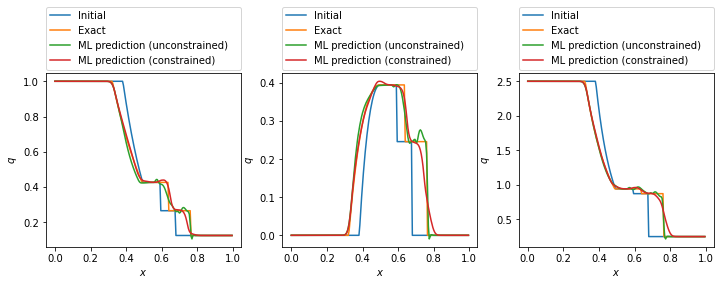

In [32]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))
plt.tight_layout()
for vid in range(3):
    ax[vid].plot(ee.x, ee.q0[:,vid], label='Initial')
    ax[vid].plot(ee.x, ee.q_tru[:,vid], label='Exact')
    ax[vid].plot(ee.x, sol_u[:,vid], label='ML prediction (unconstrained)')
    ax[vid].plot(ee.x, sol_c[:,vid], label='ML prediction (constrained)')
    ax[vid].set_xlabel(r'$x$')
    ax[vid].set_ylabel(burg.varnames[0])
    ax[vid].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=1)

## Scenario #4: Advection-anti-diffusion

Demo for 1D advection-anti-diffution problem in Section 3.4.
We first define a generalized constrained NN closure model (3.9) to incorporate non-hyperbolic behaviors.

In [42]:
class nnSolverConstrainedNonhyper(nnSolverConstrained):
    """1D PDE solver with non-hyperbolic constrained NN closure (3.9)."""
    def __init__(self, *args, mu):
        """
        Parameters
        ----------
        mu : float
            Constant diffusivity for reference
        """
        super(nnSolverConstrainedNonhyper, self).__init__(*args)
        self.mu = mu # constant for scaling diffusivity
        Ni, Nh, No = args[0]
        self.nup = baseNN(Ni*2, Nh, No) # \nu^+ (3.10)
        self.num = baseNN(Ni*2, Nh, No) # \nu^- (3.10)
        self.models = nn.ModuleList([
            self.f,
            self.nup,
            self.num
        ]) # override NN modules
        self.optimizer = optim.RMSprop(
            self.models.parameters(),
            lr=1e-3
        )
    
    def varphi(self, a, b):
        """Flux limiter (3.11).
        
        Parameters
        ----------
        a : Tensor
            First state.
        b : Tensor
            Second state.
        
        Returns
        -------
        out : Tensor
            Evaluated flux limiter values.
        """
        out = torch.where(
            torch.logical_and(a>0, b>0),
            torch.minimum(
                torch.minimum(a, 1/a),
                torch.minimum(b, 1/b)
            ),
            0*a
        )
        return out
    
    def rhs(self, q):
        """Overrides constrained NN RHS without diffusivity."""
        # Reconstruct
        qb = self.prolongate(q)
        qp = torch.roll(qb, -1, 0)
        qm = torch.roll(qb, +1, 0)
        s = self.minmod(qp-qb, qb-qm) # limited slope
        qr = qp - 0.5*torch.roll(s, -1, 0)
        ql = qb + 0.5*s
        
        # Compute flux and wave speed
        fr, ar = self.get_f_a(qr)
        fl, al = self.get_f_a(ql)
        a = torch.maximum(ar, al) # a_{i+1/2}
        self.amax = max(self.amax, torch.max(a))
        
        # NN diffusivity
        eps = 1e-12
        r = (qb-qm+eps)/(qp-qb+eps) # slope ratio
        q_in = torch.cat((qp, qb), dim=1)
        varphi = self.varphi(r, torch.roll(r, -1, 0)) # flux limiter
        nu = torch.abs(self.nup(q_in)) + varphi*self.num(q_in) # NN diffusivity
        
        fph = 0.5*(fr+fl-a*(qr-ql)) - self.mu*nu*(qp-qb)/self.dx
        fmh = torch.roll(fph, 1, 0)
        rhs = -(fph-fmh)/self.dx
        rhs_i = self.restrict(rhs) # restrict RHS
        return rhs_i

In [43]:
class antidiffusion(advection):
    """Config for advection-antidiffusion equation."""
    def __init__(self):
        self.mu = 0.001
        super(antidiffusion, self).__init__()
        self.q0, self.q_tru = self.getExactSol()
        self.solver_n = nnSolverConstrainedNonhyper(
            (1, self.Nh, 1),
            self.dt,
            self.dx,
            self.bc,
            self.q0,
            self.q_tru,
            self.Nt,
            mu=self.mu) # add a non-hyperbolic model
        self.solvers.append(self.solver_n)
        
    def getExactSol(self):
        """Get exact solutions of 1D advection-anti-diffusion equation."""
        q_tru = torch.where(
            self.x>0.5,
            torch.ones_like(self.x),
            torch.zeros_like(self.x)
        )
        q0 = q_tru.clone()
        for i in range(self.Nt):
            q0 += self.dt/self.dx**2*self.mu*\
                    (torch.roll(q0, -1)-2*q0+torch.roll(q0, +1))
        q_tru = torch.roll(q_tru, int(self.Nx*self.tf))
        return q0.view(-1,1), q_tru.view(-1,1)

#### Train the model

In [44]:
ad = antidiffusion()
ad.train(ad.solver_u)  # unconstrained solver
ad.train(ad.solver_c)  # constrained solver
ad.train(ad.solver_n)  # constrained non-hyperbolic solver

100%|██████████| 1000/1000 [00:35<00:00, 28.26it/s]


Initial loss: 0.37777547683121676
Final loss: 0.005486147347422128


100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s]


Initial loss: 0.37777547683121676
Final loss: 0.007382209272326349


100%|██████████| 1000/1000 [03:38<00:00,  4.59it/s]

Initial loss: 0.37777547683121676
Final loss: 0.004073146827187745


#### Apply the model

In [45]:
sol_u = ad.solver_u.solve().detach()  # solve with the unconstrained model
sol_c = ad.solver_c.solve().detach()  # solve with the constrained model
sol_n = ad.solver_n.solve().detach()  # solve with the constrained non-hyperbolic model

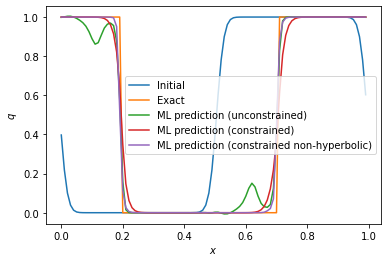

In [46]:
fig, ax = plt.subplots()
ax.plot(ad.x, ad.q0, label='Initial')
ax.plot(ad.x, ad.q_tru, label='Exact')
ax.plot(ad.x, sol_u, label='ML prediction (unconstrained)')
ax.plot(ad.x, sol_c, label='ML prediction (constrained)')
ax.plot(ad.x, sol_n, label='ML prediction (constrained non-hyperbolic)')
ax.set_xlabel(r'$x$')
ax.set_ylabel(ad.varnames[0])
plt.legend()